## Gaussian Process

In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI
from pyro.optim import Adam
from pyro.params import param_with_module_name
from pyro.util import ng_ones, ng_zeros

In [2]:
class RBFKernel(nn.Module):
    def __init__(self, variance=torch.ones(1), lengthscale=torch.ones(1)):
        super(RBFKernel, self).__init__()
        self.variance = nn.Parameter(variance)
        self.lengthscale = nn.Parameter(lengthscale)
    
    def forward(self, x, z=None):
        if z is None:
            z = x
        lengthscale = self.lengthscale
        x = x / lengthscale
        z = z / lengthscale
        xz = x.ger(z)
        xx = x.unsqueeze(1) ** 2
        zz = z.unsqueeze(0) ** 2
        k = self.variance * torch.exp(-0.5 * (xx - 2*xz + zz))
        return k
    
    def K(self, X, Z=None):
        return self(X, Z)

In [3]:
class MultivariateNormalTriL(dist.Distribution):
    reparameterized = True
    
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
        super(MultivariateNormalTriL, self).__init__()

    def batch_shape(self, x=None):
        event_dim = 1
        loc = self.loc
        if x is not None:
            loc = self.loc.expand_as(x)
        return loc.size()[:-event_dim]

    def event_shape(self):
        event_dim = 1
        return self.loc.size()[-event_dim:]

    def sample(self):
        eps = Variable(torch.randn(self.loc.size()))
        z = self.loc + self.scale.matmul(eps)
        return z if self.reparameterized else z.detach()

    def batch_log_pdf(self, x):
        log_Z = (0.5 * self.loc.size(0) * Variable(torch.Tensor([2*math.pi])).log()
                 + self.scale.diag().log().sum())
        y = self.scale.inverse().matmul(x - self.loc)
        return -0.5 * y.pow(2).sum() - log_Z

### model

In [4]:
class GPRegressor(nn.Module):
    def __init__(self, X, y, kernel, priors={}, noise=0.01):
        super(GPRegressor, self).__init__()
        self.X = X
        self.y = y
        self.N = self.X.size(0)
        self.kernel = kernel
        self.priors = priors
        self.noise = ng_ones(1) * noise
        
    def model(self):
        kernel_fn = pyro.random_module("kernel", self.kernel, self.priors)
        kernel = kernel_fn()
        K = kernel.K(self.X) + self.noise.repeat(N).diag()
        L = K.potrf(upper=False)
        y = pyro.sample("f", MultivariateNormalTriL(ng_zeros(self.N), L), obs=self.y)
        
    def guide(self):
        guide_priors = {}
        for p in self.priors:
            p_MAP_name = param_with_module_name("kernel", p) + "_MAP"
            p_MAP = pyro.param(p_MAP_name, Variable(self.priors[p].analytic_mean().detach(),
                                                    requires_grad=True))
            guide_priors[p] = dist.Delta(p_MAP)
        kernel_fn = pyro.random_module("kernel", self.kernel, guide_priors)
        kernel = kernel_fn()
        return kernel
        
    def fit(self, lr=0.001, n_iter=1000):
        pyro.clear_param_store()
        optim = Adam({"lr": lr})
        svi = SVI(self.model, self.guide, optim, loss="ELBO", trace_graph=True)
        losses = []
        for i in range(n_iter):
            losses.append(svi.step())
        return losses
    
    def forward(self, Z):
        kernel = self.guide()
        K = kernel.K(self.X) + self.noise.repeat(self.N).diag()
        K_xz = kernel(self.X, Z)
        K_zx = K_xz.t()
        K_zz = kernel.K(Z)
        loc = K_zx.matmul(self.y.gesv(K)[0]).squeeze(1)
        scale = K_zz - K_zx.matmul(K_xz.gesv(K)[0])
        return loc, scale

In [5]:
def plot(model=None, n_sample=0):
    plt.figure(figsize=(12, 6))
    plt.plot(X.data.numpy(), y.data.numpy(), 'kx')
    if model is not None:
        Z = Variable(torch.linspace(-0.5, 5.5, 100), volatile=True)
        mean, cov = model(Z)
        sd = cov.diag().sqrt()
        plt.plot(Z.data.numpy(), mean.data.numpy(), 'r', lw=2)
        plt.fill_between(Z.data.numpy(),
                         mean.data.numpy() - 2*sd.data.numpy(),
                         mean.data.numpy() + 2*sd.data.numpy(),
                         color='C0', alpha=0.3)
    if n_sample > 0:
        samples = np.random.multivariate_normal(mean.data.numpy(), cov.data.numpy(),
                                                size=n_sample, check_valid='ignore')
        plt.plot(Z.data.numpy(), samples.T, 'C0', lw=2, alpha=0.4)
    plt.xlim(-0.5, 5.5)
    plt.ylim(-3, 3)

### Define data

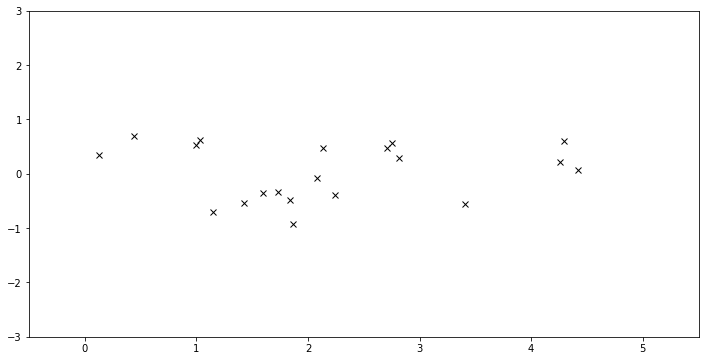

In [6]:
# http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
N = 20
X = dist.Uniform(ng_zeros(N), ng_ones(N)*5).sample()
y = 0.5 * torch.sin(3*X) + dist.Normal(ng_zeros(N), ng_ones(N)*0.5).sample()
plot()

### Define model

In [7]:
kernel = RBFKernel()
model = GPRegressor(X, y, kernel)

#### Plot model with initial parameters

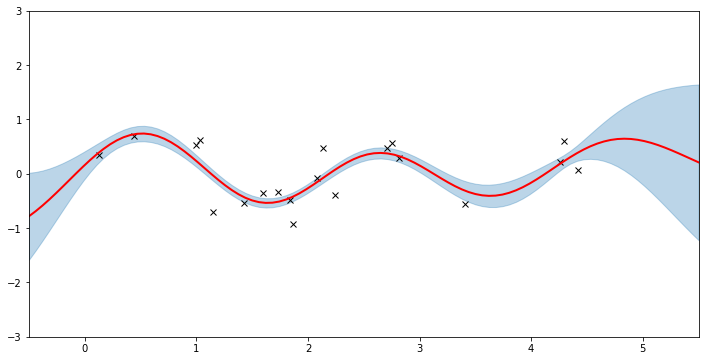

In [8]:
plot(model)

### Fit the model using MLE

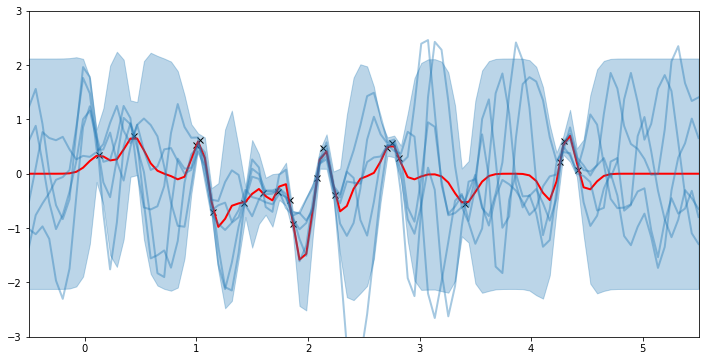

In [9]:
losses = model.fit()
plot(model, n_sample=5)

#### Observe the loss

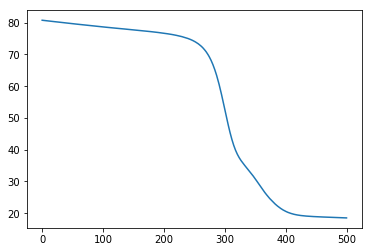

In [10]:
plt.plot(losses[-500:])

#### Observe the parameters

In [11]:
pyro.get_param_store().named_parameters()

dict_items([('kernel$$$variance', Parameter containing:
 1.1232
[torch.FloatTensor of size 1]
), ('kernel$$$lengthscale', Parameter containing:
1.00000e-02 *
  9.4788
[torch.FloatTensor of size 1]
)])

The larger lengthscale, we get the smoother samples. (explain) Variance control the derivation from the mean. (besides the fixed noise `0.01`)

Note that these parameters should be positive. To force such constraint, we need to use some kind of transform (e.g. `exp` or `softplus`). (more on this)

### Fit the model using MAP

We need to define the priors for parameters. Beside it is more reliable approach, it will also help dealing with the constraints of parameters.

In [12]:
# TODO

### Obstacles

+ Some (fast) LAPACK operator to work with triangle matrix such as `potrs` and `trtrs` are not differentiable (Pytorch 3.0).

+ Cholesky decomposition `potrf` usually throw the error "not positive definite matrix" (when we remove the noise from the model). So, instead of sampling $f$ from the decomposed lower triangle $L$ of $K(X, X)$ and sampling $y$ from $f$ with `noise`, we have to add `noise` to $K$ before decomposing matrix. (Another way is to use the notion `jitter` before decomposing the covariance matrix.)

### What next? (not covered in this tutorial)

+ Extend to high dimensional data.
+ Things like Likelihood, Mean functions can be made modular (`nn.Module`) like Kernel.
+ Spare GPs: using pseudo (inducing) points.